In [1]:
import os
from glob import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.utils import set_determinism, first
from monai.inferers import sliding_window_inference

In [136]:
def preprocess_nifti(filepath, weights_dir='D:/GraduateWorkData/nifti_files2/22vs8/results/best_metric_model.pth',
                     pixdim=(2, 2, 1.5), a_min=-100, a_max=400, spatial_size=[128, 128, 64], cache=True):
    path_dict = {'vol': filepath}

    transforms = Compose(
        [
            LoadImaged(keys=['vol']),
            EnsureChannelFirstD(keys=['vol']),
            Spacingd(keys=['vol'], pixdim=pixdim, mode='nearest'),
            #Spacingd(keys='vol', pixdim=pixdim, mode='bilinear'),
            Orientationd(keys=['vol'], axcodes='RAS'),
            ScaleIntensityRanged(keys=['vol'], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol'], source_key='vol'),
            Resized(keys=['vol'], spatial_size=spatial_size),
            ToTensord(keys=['vol']),
        ]
    )   

    dataset = Dataset(data=[filepath], transform=transforms)
    data_loader = DataLoader(dataset, batch_size=1)

    # print('DATASET: ', len(dataset))
    # print(dataset.data['vol'])

    print('LOADER: ')
    print(first(data_loader)['vol'].shape)
        

    device = torch.device("cuda:0")
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)

    model.load_state_dict(torch.load(
        weights_dir
    ))

    model.eval()



    sw_batch_size = 4
    roi_size = (128, 128, 64)
    with torch.no_grad():
        processed_images = []
    
        test_patient = first(data_loader)
        t_volume = test_patient['vol']

        test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
        #sigmoid_activation = Activations(sigmoid=True)
        sigmoid_activation = torch.nn.Sigmoid()

        test_outputs = sigmoid_activation(test_outputs)
        test_outputs = test_outputs > 0.33

        print('TEST OUTPUTS: ', test_outputs.shape)

        print('shape[-1] = ', test_patient['vol'].shape[-1])

        for i in range(test_patient['vol'].shape[-1]):
            if i >= 50:
                processed_image = test_outputs.detach().cpu()[0, 1, :, :, i]
                processed_images.append(processed_image)

                plt.figure("check", (18, 6))
                plt.subplot(1,2,1)
                plt.title(f"image {i}")
                plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
                plt.subplot(1,2,2)
                plt.imshow(processed_image)

                plt.show()
        #max_img = max(processed_images, key=lambda x: np.sum(x))

        #plt.imshow(max_img)
        #plt.show()
        #print('SHAPE = ', max_img.shape)

LOADER: 
torch.Size([1, 1, 128, 128, 64])
TEST OUTPUTS:  torch.Size([1, 2, 128, 128, 64])
shape[-1] =  64


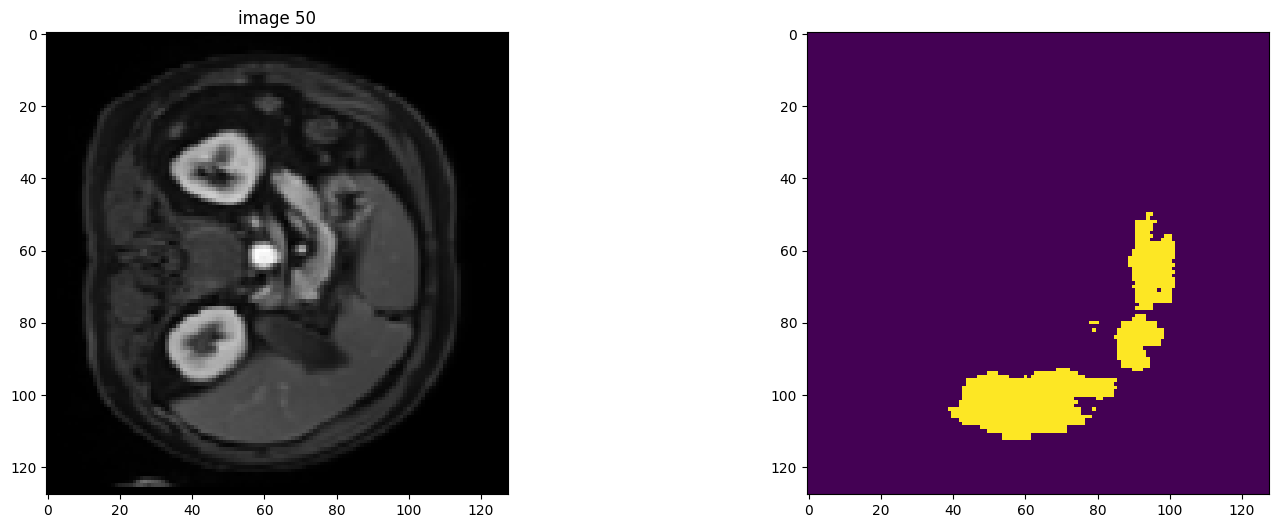

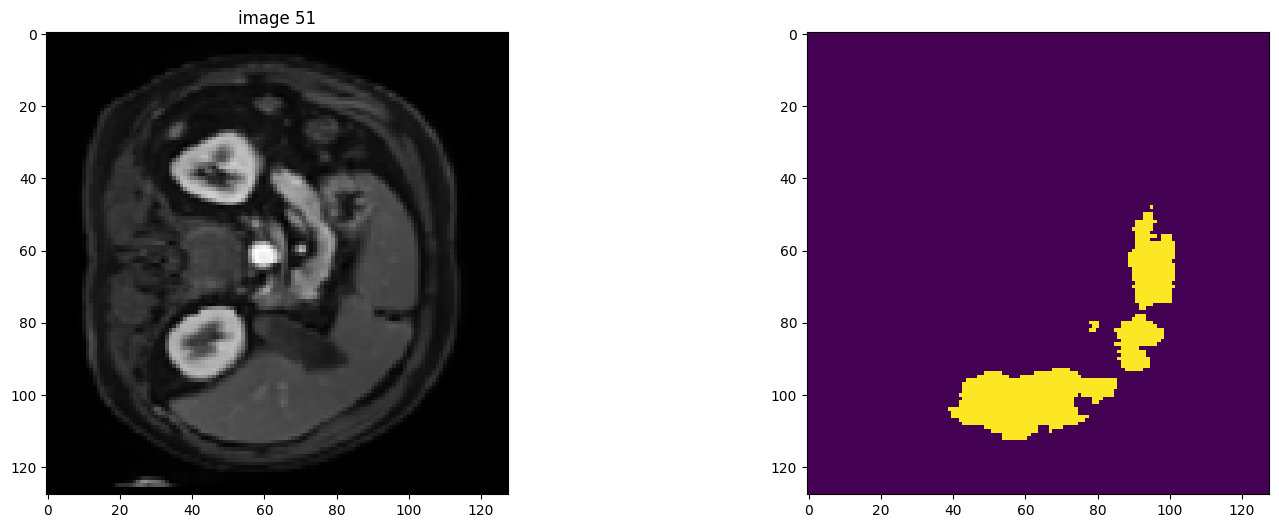

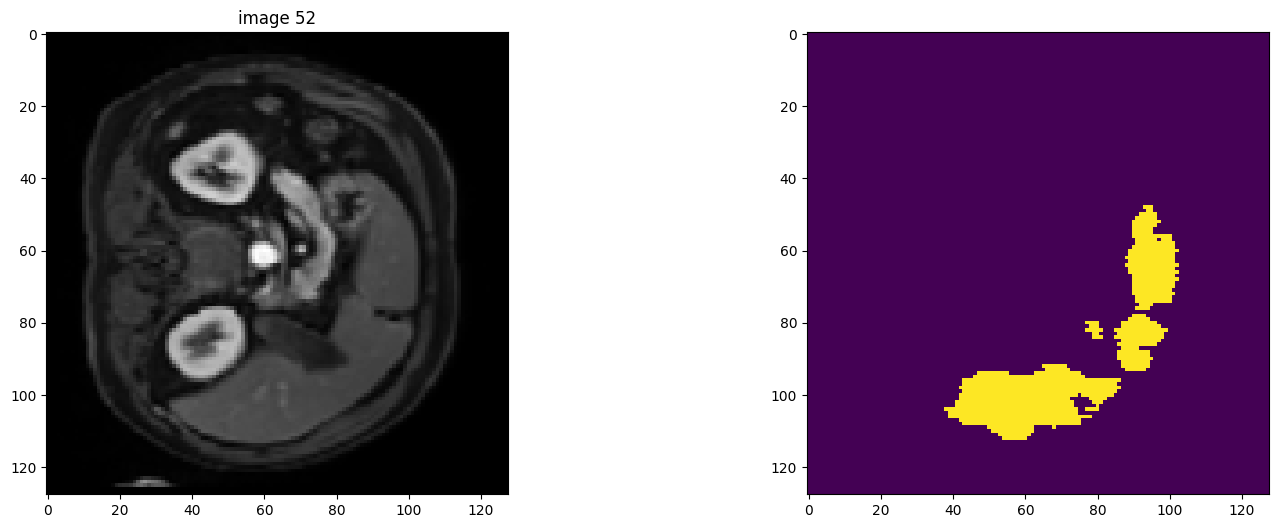

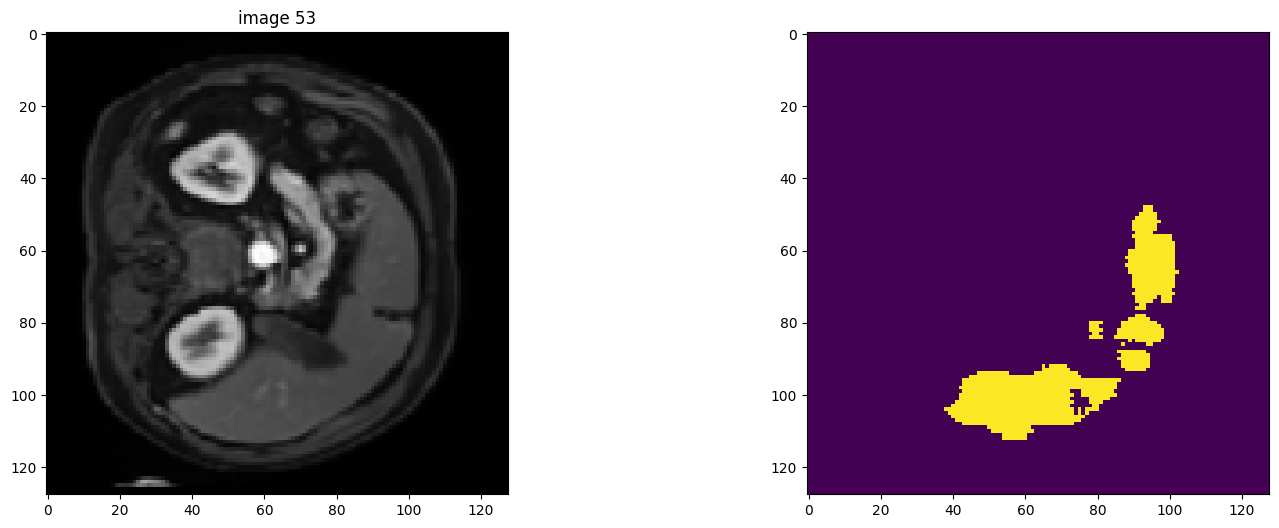

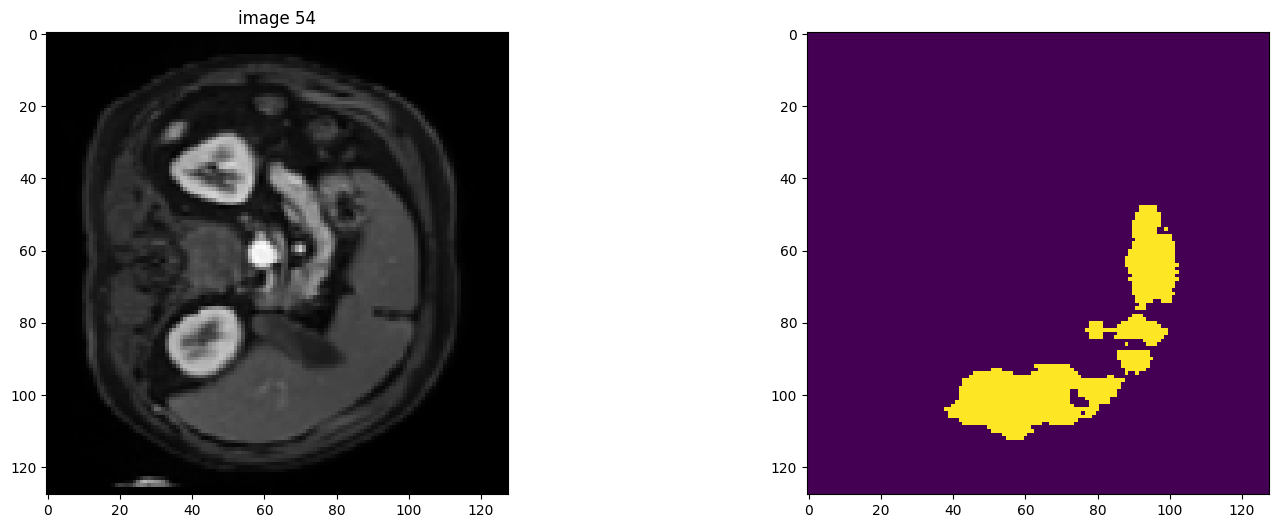

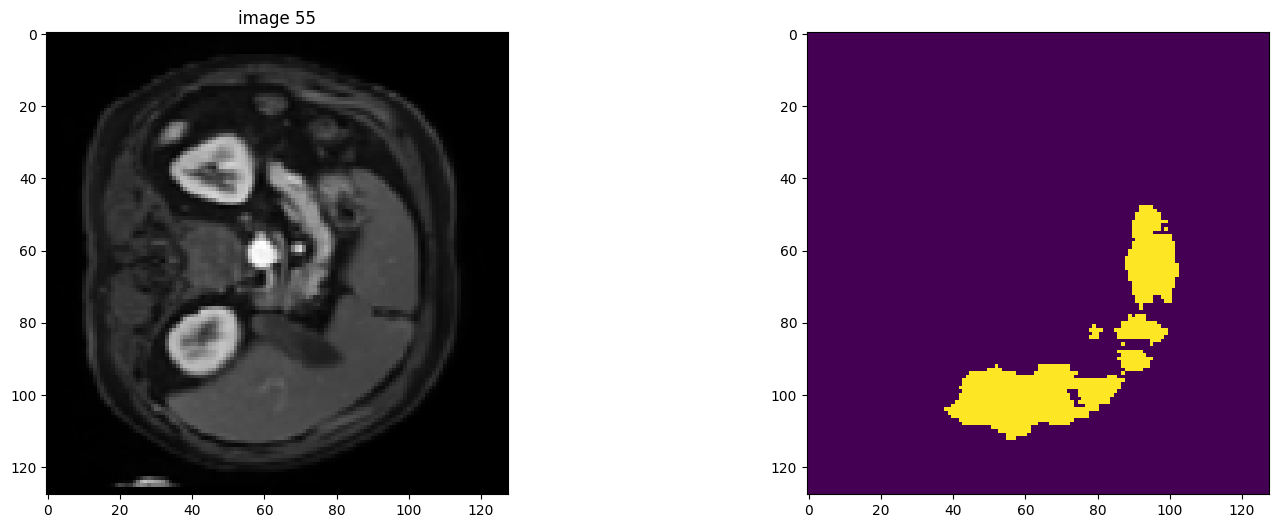

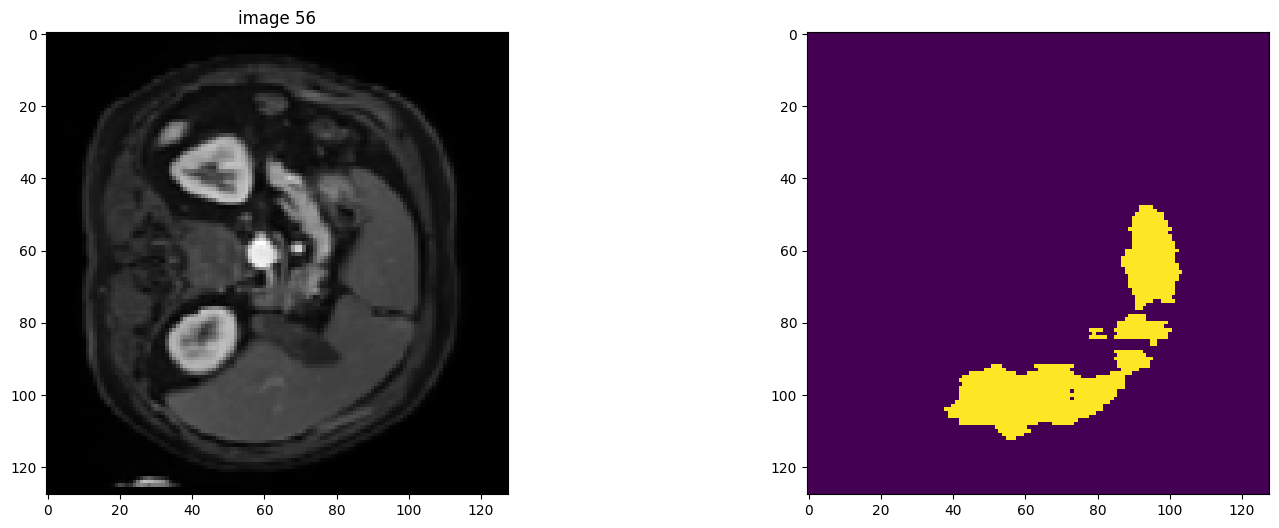

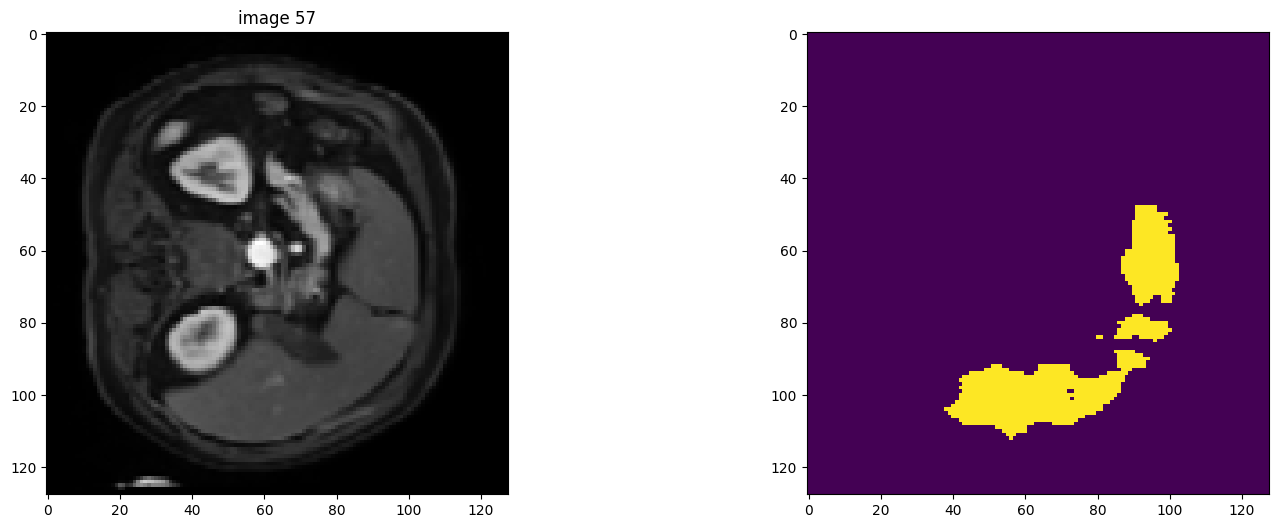

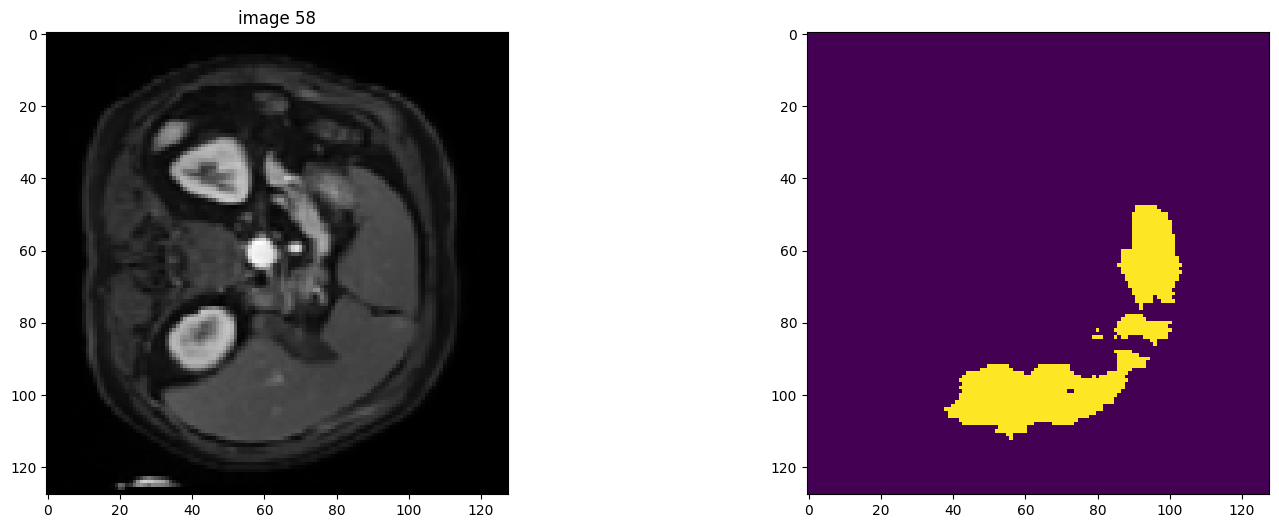

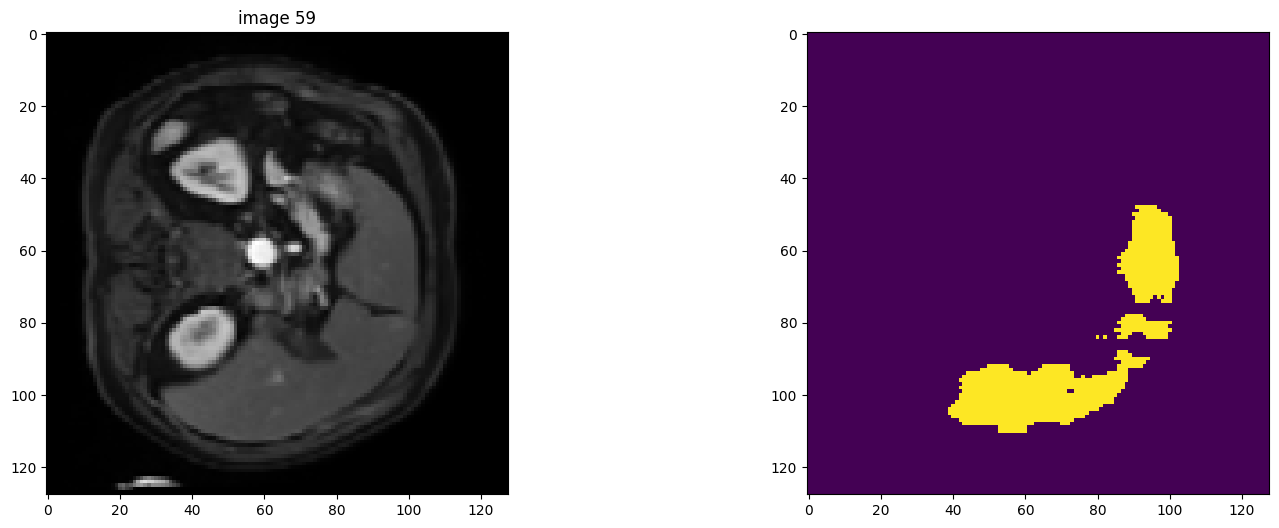

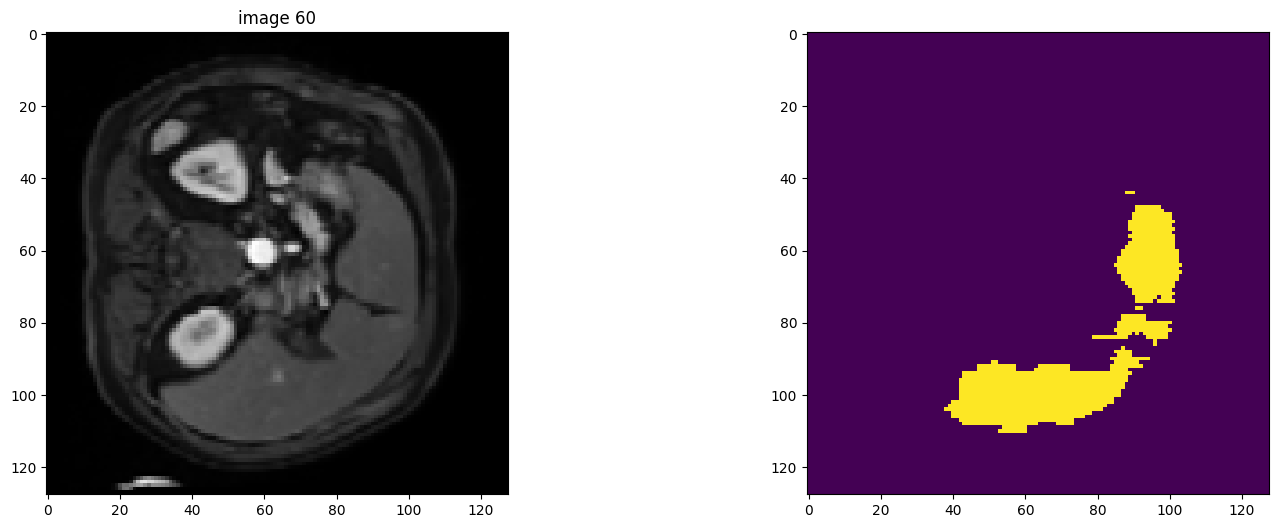

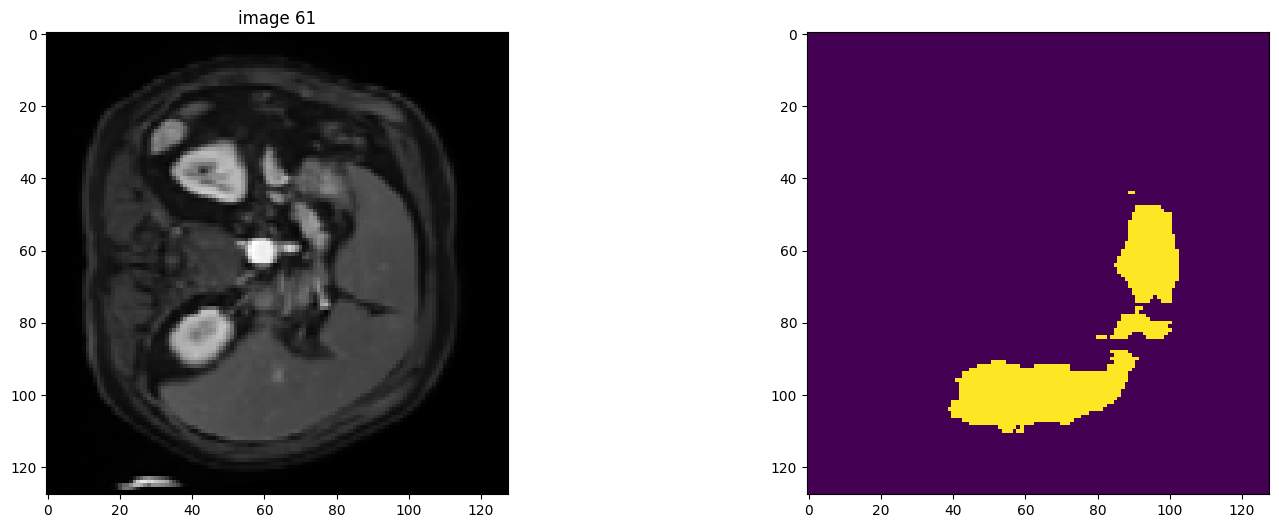

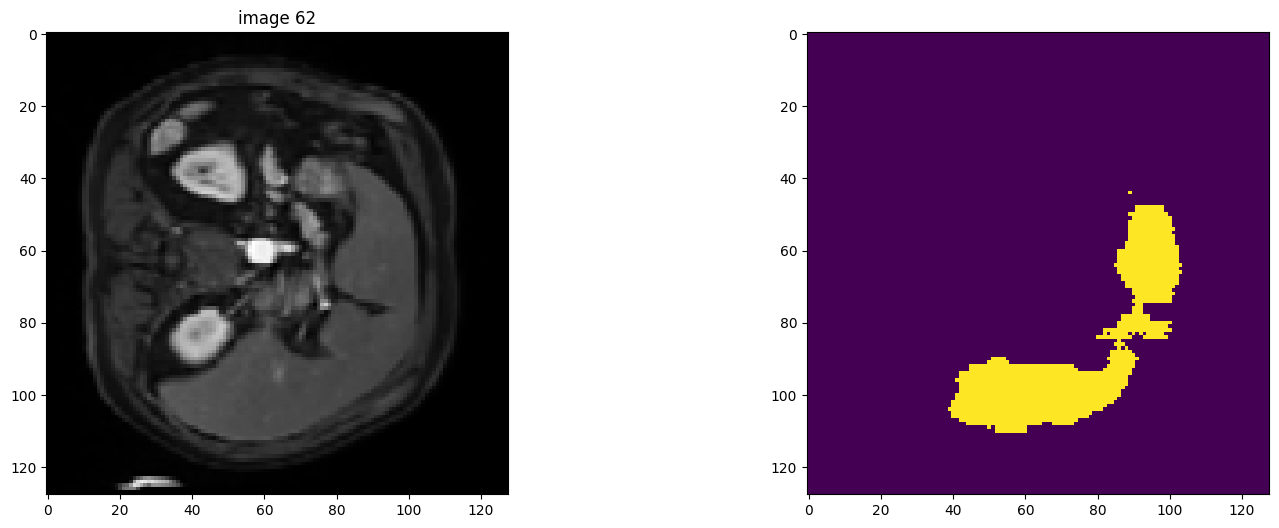

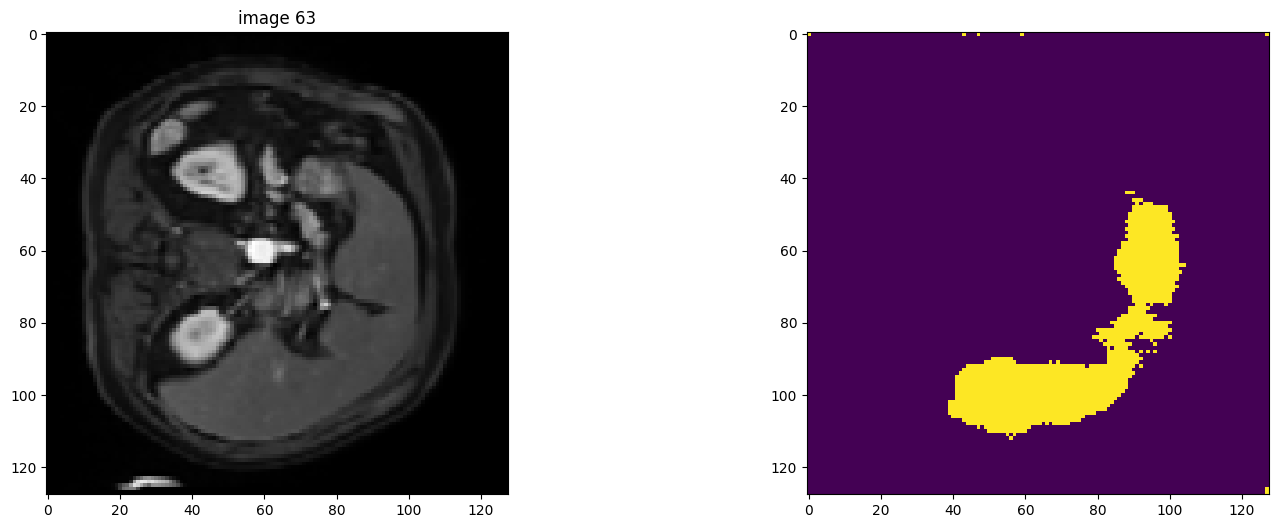

In [137]:
filepath = {'vol': 'D:/универ (D)/4 КУРС/диплом/LiverMeterApp/Images/Uploaded/liver_11_0.nii.gz'}

preprocess_nifti(filepath=filepath)

In [1]:
from monai.utils import first
from monai.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    ToTensord,
)

In [2]:
data_path = "D:/GraduateWorkData/nifti_files2/22vs8/TestImages/liver_11_0.nii.gz"

In [4]:
transforms = Compose(
        [
            LoadImaged(keys=['volume']),
            #EnsureChannelFirstD(keys=['volume']),
            Spacingd(keys=["volume", "label"], 
            pixdim=(2, 2, 1.5), mode=("bilinear", "nearest")),
            Orientationd(keys=["volume", "label"], 
            axcodes="RAS"),
            ScaleIntensityRanged(keys=["volume"], a_min=-100, 
            a_max=400, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["volume", "label"], 
            source_key="volume"),
            Resized(keys=["volume", "label"], 
            spatial_size=(128, 128, 64),
            ToTensord(keys=["volume", "label"]),
        ]
    )

In [5]:
data_dict = [{'volume', data_path}]

dataset = Dataset(data_dict, transform=transforms)
data_loader = DataLoader(dataset, batch_size=1)

In [7]:
first(data_loader)

RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x0000024D3D783B10>